
<h1><b><center>Programming Assignment I : </center></b></h1>
<h1><b><center>Gaussian Process Regression</center></b></h1>
<h5><b><center> Amatya Sharma </center></b></h5>
<h5><b><center> 17CS30042 </center></b></h5>

Dependencies and Variables : 
- We are predicting for Xtest, if user wants to predict for custom values, modify Xtest and Ytest correspndingly in cell 3.
- Xtrain := Trianing Data with only one feature i.e. Day Number
- Ytrain := Training Values Corresponding to Xtrain
- Ytrain_India := Ytrain for India
- Ytrain_World := Ytrain for World
- Xtest := Test Data with only one feature i.e. Day Number
- Ytest := Actual Test Values Corresponding to Xtest will be used for checking accuracy of the models
- Ytest_India := Ytest for India
- Ytest_World := Ytest for World
- K = Kernel(Xtrain, Xtrain)
- K_s = kernel(Xtrain, Xtest)
- K_ss = kernel(Xtest, Xtest)
- sigma_f := 1st hyperparam for the squared exponential kernel function
- l := 1st hyperparam for the squared exponential kernel function
- sigma_y := given gaussian noise error variance
- mu_s := PPD predicted mean vector corresp to PPD Gaussian Distribution
- sigma_s := PPD predicted mean vector corresp to PPD Gaussian Distribution



In [22]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import cholesky, det, lstsq
import pandas

# !pip install pymc3
import pymc3 as pm

import theano
import theano.tensor as tt
%matplotlib inline
np.random.seed(10)
# from scipy.optimize import minimize/

In [ ]:
# read data
df = pandas.read_csv('new_casesWorld-India.csv')
data = df.values

# partition into training and test sets
# partiton into data from world and india
Xtrain = data[0:245,0]
Ytrain_World = data[0:245,2]
Ytrain_India = data[0:245,3]

Xtest = data[246:, 0]
Ytest_World = data[246:, 2]
Ytest_India = data[246:, 3]

# convert all arrays to numpy arrays to enable them to perform numpy array/matrix operations
Xtrain = np.array(Xtrain)
Ytrain_World = np.array(Ytrain_World)
Ytrain_India = np.array(Ytrain_India)
Xtest = np.array(Xtest)
Ytest_World = np.array(Ytest_World)
Ytest_India = np.array(Ytest_India)


In [44]:
# A one dimensional column vector of inputs.
# X = Xtrain
# X = X.reshape((245,1))
# X = X/250
X = np.linspace(0,244,245)[:,None]
# X = np.linspace(0, 1, 10)[:, None]
print(type(X))
y = Ytrain_India
# y = np.random.rand(10)

# A smaller set of inducing inputs
# Xu = np.linspace(0, 1, 245)[:, None]
# Xu = Xtrain[40:100]
# Xu = Xu.reshape((60,1))
# Xu = Xu/250
Xu = np.linspace(130,200,70)[:,None]

print(np.shape(X), np.shape(y), np.shape(Xu))



with pm.Model() as model:
    # Specify the covariance function.
    cov_func = pm.gp.cov.ExpQuad(1, ls=0.1)

    # Specify the GP.  The default mean function is `Zero`.
    # gp = pm.gp.Latent(cov_func=cov_func)
    gp = pm.gp.MarginalSparse(cov_func=cov_func, approx="FITC")

    # Place a GP prior over the function f.
    sigma = pm.HalfCauchy("sigma", beta=3)
    y_ = gp.marginal_likelihood("y", X=X, Xu=Xu, y=y, noise=sigma)
    
    trace = pm.sample(1000)
    print(trace, "\n")

...



# pm.traceplot(trace);

# After fitting or sampling, specify the distribution
# at new points with .conditional
Xnew = np.linspace(-1, 2, 50)[:, None]

with model:
    fcond = gp.conditional("fcond", Xnew=Xnew)


<class 'numpy.ndarray'>
(245, 1) (245,) (70, 1)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma]


ValueError: Not enough samples to build a trace.

In [ ]:
# kernel function for guasiian processes
# kernel function is only for vectors not for matrices as our inputs are 1-D
# we use squared exponential kernel
# with hyperparameters sigma_f and l 


# funtion to caluculate kernel of 2 scalars

def rbf_kernel_util(sigma_f, x1, x2):
    return np.exp(-(x1-x2)**2/(2* sigma_f**2))

def sqexp_kernel_util(x1, x2, l, sigma_f):
    return sigma_f*sigma_f * np.exp(-0.5/(l*l) * (x1-x2)*(x1-x2))

# funtion to calculate SE Kernel of two input vectors
def kernel(X1, X2, l, sigma_f):
    l1 = len(X1)
    l2 = len(X2)
    K = np.zeros((l1, l2))
    
    #iterate over all indices of the covariance matrix to fill it with k(i,j)
    for i in range(l1):
        for j in range(l2):
            K[i][j] = sqexp_kernel_util(X1[i], X2[j], l, sigma_f)
    return K

def kernel_visualize(X_visualize, X_visualize2, l, sigma_f):
    K_visualize = kernel(X_visualize, X_visualize2, l, sigma_f)

    figre, axs = plt.subplots()
    plt.imshow(K_visualize, interpolation='none')
    plt.title("Covariance Matrix")
    axs.set_ylim(axs.get_ylim()[::-1])
    plt.colorbar()
    plt.show()
#to-do write some features of hyper parameters

In [ ]:
# visualizing the kernel matrix for first 20 values
# the concentration can be seen along diagonal values due to the properties of Squared Exponential Kernel
sigma_f = 5
l = 50

print("Histogram of K(Xtrain, Xtrain):")
kernel_visualize(Xtrain, Xtrain, l, sigma_f)

print("Histogram of K(Xtest, Xtest):")
kernel_visualize(Xtest, Xtest, l, sigma_f)

print("Histogram of K(Xtrain, Xtest):")
kernel_visualize(Xtrain, Xtest, l, sigma_f)


In [ ]:
#visualize GP of  Finite number of points

Xplot = Xtest
numplot = len(Xplot)
Kplot = kernel(Xplot, Xplot, .1, 1)

rand_draw_prior = np.dot(Kplot, np.random.normal(size=(numplot, 4)))

figre, axs = plt.subplots()
variances = np.diag(Kplot) # diagonal elements are individual vairance
std_dev = np.sqrt(variances)

# plt.fill_between(Xplot.reshape(-1), 1.96 * std_dev,  - 1.96 * std_dev, alpha=0.1)

plt.plot(Xplot, rand_draw_prior)
plt.plot(Xplot, np.zeros(len(Xplot)), label='Mean')
plt.title("GP Prior Train of 4 samples")
plt.xlabel("Variable")
plt.ylabel("Value")
plt.legend()
plt.show()

In [ ]:
def Cinv(K, sigma_y):
    K_inv = np.linalg.inv(K + (sigma_y*sigma_y)*np.eye(len(Xtrain)))
    return K_inv

def posterior_predictive(Xtrain, Ytrain, l, sigma_y, sigma_f, X):
    cov_s = 0.0
    K_ss = kernel(X, X, l, sigma_f)
    K_s = kernel(Xtrain, X, l, sigma_f)

    mu_s = 0.0
    K = kernel(Xtrain, Xtrain, l, sigma_f)
    K_inv = Cinv(K, sigma_y)
    
    sigma_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    mu_s = K_s.T.dot(K_inv).dot(Ytrain)
    
    return mu_s, sigma_s

In [ ]:
def predict_and_plot(Xtrain, Ytrain, l, sigma_f, sigma_y, Xtest, Ytest): 
    mu, sigma = posterior_predictive(Xtrain, Ytrain, l, sigma_y, sigma_f, Xtest)

    figr, axs = plt.subplots()

    plt.plot(Xtrain, Ytrain, 'c')
    plt.plot(Xtest, Ytest, 'c--')
    plt.plot(Xtest, mu, 'g')
    plt.xlabel("Day Number")
    plt.ylabel("Number of Cases")
    plt.legend(["Training", "Test","Prediction"])
    plt.title("Data and Predictions : Big Picture")

    plt.show()
    
    if Xtrain.all() == Xtest.all():
        return mu, sigma

    plt.plot(Xtest, Ytest)
    plt.plot(Xtest, mu)
#     pred = np.array(mu)
#     pred = pred.T
#     sgma = np.array(sigma)
#     plt.errorbar(Xtest, pred, yerr = sgma, capsize = 0)
    plt.xlabel("Day Number")
    plt.ylabel("Number of Cases")
    plt.legend(["Test", "Prediction"])
    plt.title("Zoomed in View on Test set")
    plt.show()  
    
    plt.imshow(sigma, interpolation='none')
    plt.title("Covariance Matrix PPD")
    axs.set_ylim(axs.get_ylim()[::-1])
    plt.colorbar()
    plt.show()
    
    return mu, sigma

In [ ]:
# 100 1 
l= 95
sigma_f= .6
sigma_y=.1

print("Fitting Train Data - India on Self-fed HyperParameters:")
mu_india, sigma_india = predict_and_plot(Xtrain, Ytrain_India, l, sigma_f, sigma_y, Xtrain, Ytrain_India)                         


print("Predictions - India on Self-fed HyperParameters:")
mu_india, sigma_india = predict_and_plot(Xtrain, Ytrain_India, l, sigma_f, sigma_y, Xtest, Ytest_India)                         

# kernel_visualize()

print("(India)Mean values of predictions with guessed hyperparams day 246 onwards:\n", mu_india, "\n\nSigma:\n", sigma_india)

In [ ]:
# 75 15
l= 75
sigma_f= 15
sigma_y=.1

print("Fiited Train Data - World on Self-fed HyperParameters:")
mu_world, sigma_world = predict_and_plot(Xtrain, Ytrain_World, l, sigma_f, sigma_y, Xtrain, Ytrain_World)                         

print("Predictions - World on Self-fed HyperParameters:")
mu_world, sigma_world = predict_and_plot(Xtrain, Ytrain_World, l, sigma_f, sigma_y, Xtest, Ytest_World)                         

print("(World)Mean values of predictions with guessed hyperparams day 246 onwards:\n", mu_world, "\n\nSigma:\n", sigma_world) 

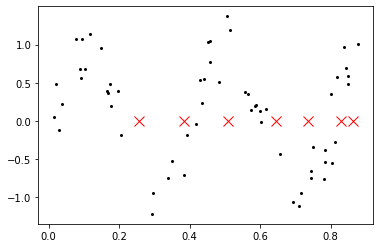

In [43]:
# nx, nu = 60, 7
# x = np.random.rand(nx)
# xu = np.random.rand(nu)
# # y = np.sin(2 * np.pi * x * 2.5) + 0.3 * np.random.randn(nx)

# plt.plot(x, y, 'ko', ms=2);
# plt.plot(xu, 0.0*np.ones(len(xu)), 'rx', ms=10)
# x = x[:,None]; xu = xu[:,None]
# xs = np.linspace(-0.1, 1.1, 100)

In [27]:
# with pm.Model() as model:
#     ℓ = pm.Gamma("ℓ", alpha=1.5, beta=0.5)
#     σ_f = pm.HalfCauchy("σ_f", beta=5)
#     σ_n = pm.HalfCauchy("σ_n", beta=5)
#     cov = tt.square(σ_f) * pm.gp.cov.Matern52(1, ℓ)
#     gp = pm.gp.GP("gp", x, cov, sigma=σ_n, inducing_points=xu, observed=y)
#     trace = pm.sample(1000)

AttributeError: module 'pymc3.gp' has no attribute 'GP'

In [42]:
# A one dimensional column vector of inputs.
X = np.linspace(0, 1, 10)[:, None]

# A smaller set of inducing inputs
Xu = np.linspace(0, 1, 5)[:, None]

with pm.Model() as model:
    # Specify the covariance function.
    cov_func = pm.gp.cov.ExpQuad(1, ls=0.1)

    # Specify the GP.  The default mean function is `Zero`.
    gp = pm.gp.MarginalSparse(cov_func=cov_func, approx="FITC")

    # Place a GP prior over the function f.
    sigma = pm.HalfCauchy("sigma", beta=3)
    y_ = gp.marginal_likelihood("y", X=X, Xu=Xu, y=y, noise=0.1)

...

# After fitting or sampling, specify the distribution
# at new points with .conditional
Xnew = np.linspace(-1, 2, 50)[:, None]

with model:
    fcond = gp.conditional("fcond", Xnew=Xnew)

ValueError: operands could not be broadcast together with shapes (60,) (10,) 

In [ ]:
# # hyper parameter optimization util function
# def hyperparameter_opt(sigma_f, l, Xtrain, Ytrain, Xtest, Ytest):
#     print("------------LOG OF OPTIMIZATION ALGORITHM - BEGIN------------")
#     min_err = 9999999999.0
#     sig_opt = 9999.0 
#     l_opt = 9999.0 
#     sig = max(sigma_f - 5.0, .1)
#     sigma_lwr = sig
#     ll = max(l - 50.0, 1)
#     ll_lwr = ll
#     while sig <= sigma_lwr + 10.0:
#         ll = ll_lwr
#         while ll <= ll_lwr + 100.0:
#             mu_pred, sigma_pred = posterior_predictive(Xtrain, Ytrain, ll, sigma_y, sig, Xtest)
#             err = abs(Ytest - mu_pred)
#             err = err.sum()
#             print(sig, ll, err)
            
#             if err < min_err:
#                 min_err = err
#                 sig_opt = sig
#                 l_opt = ll
#                 print("new minima::", err, sig_opt, l_opt)
            
#             ll+=10.0
#         sig+=.5
    
    
#     print("------------LOG OF OPTIMIZATION ALGORITHM - END------------")
#     return sig_opt, l_opt


In [ ]:
# # hyperparameter optimization India
# sigma_f = .6
# l = 96
# sig_opt, l_opt = hyperparameter_opt(sigma_f, l, Xtrain, Ytrain_India, Xtest, Ytest_India)   

In [ ]:
# # 1.6 21
# # sig_opt = 1.6
# # l_opt = 21.0
# print("Optimized Hyperparams India (sigma_f, l):", sig_opt, l_opt)

In [ ]:
# print("Fitted Train Data - India on Optimized HyperParameters:")
# mu_world, sigma_world = predict_and_plot(Xtrain, Ytrain_India, l_opt, sig_opt, sigma_y, Xtrain, Ytrain_India) 

# print("Predictions - India on Optimized HyperParameters:")
# mu_india, sigma_india = predict_and_plot(Xtrain, Ytrain_India, l_opt, sig_opt, sigma_y, Xtest, Ytest_India)

# print("(INdia) Means of Predictions from optimized hyperparams day 246 onwards:\n",mu_india, "\n\nSigma :\n", sigma_india)

In [ ]:
# # hyper paramter optimization worlld
# sigma_f = 15.0
# l = 75.0
# sig_opt, l_opt = hyperparameter_opt(sigma_f, l, Xtrain, Ytrain_World, Xtest, Ytest_World)                   
    

In [ ]:
# # 5 201    
# # sig_opt = 5.0
# # l_opt = 201.0
# print("Optimized HyperParams World : (sigma_f, l)",sig_opt, l_opt)
         

In [ ]:
# print("Fitted Train Data - World on Optimized HyperParameters:")
# mu_world, sigma_world = predict_and_plot(Xtrain, Ytrain_World, l_opt, sig_opt, sigma_y, Xtrain, Ytrain_World) 

# print("Predictions - World on Optimized HyperParameters:")
# mu_world, sigma_world = predict_and_plot(Xtrain, Ytrain_World, l_opt, sig_opt, sigma_y, Xtest, Ytest_World) 

# print("(World)Mean values of predictions day 246 onwards:\n", mu_world, "\n\n Sigma:\n", sigma_world)


In [ ]:
# def nll(params,X,Y):
#     length_scale = params[0] ## Account for length scale here
#     sig_n = params[1] ## Noise std. deviation
#     K = kernel(X, X, length_scale, sig_n) + np.diag(sig_n**2*np.ones(len(X))) ## Note the change here
#     c = np.linalg.inv(np.linalg.cholesky(K))#+eps*(np.eye(len(X)))))
#     Ki = np.dot(c.T,c)
#     (sign, logdetK) = np.linalg.slogdet(K)
#     ll = -numObs/2 * np.log(np.dot(Y.T,(np.dot(Ki,Y)))) - 1/2 * logdetK
#     return -ll

# def gnll(params,X,Y):
#     length_scale = params[0] ## Account for length scale here
#     sig_n = params[1]
#     K = kernel(X, X, length_scale, sig_n) + np.diag(sig_n**2*np.ones(len(X))) ## Note the change here
#     c = np.linalg.inv(np.linalg.cholesky(K))#+eps*(np.eye(numObs))))
#     Ki = np.dot(c.T,c)
#     KiY = np.dot(Ki,Y)
#     dotK = np.dot(K,DistMat)/(length_scale**2)

#     # Compute derivatives for both components separately
#     dll_ls = (numObs)/2 * np.dot(KiY.T,np.dot(dotK,KiY))/(np.dot(Y.T,KiY))\
#             - (1/2)*(np.sum(np.diag(np.dot(Ki,dotK)))) # for length scale
#     dll_n = (numObs)/2 * np.dot(KiY.T,KiY)/(np.dot(Y.T,KiY)) - 1/2*(np.sum(np.diag(Ki))) # for noise
#     return(np.concatenate((dll_ls, dll_n), axis=0))


# initial_guess = [(0.1,0.1*np.var(YScaled_noisy))]
# HP_bounds = ((eps, 10),(eps, np.var(YScaled_noisy)))


# DistMat = Sq_Euclid_DistMat(Xtrain,Xtrain)
# res = minimize(nll, initial_guess,args=(DistMat,YScaled_noisy), method="L-BFGS-B",\
#                jac=gnll,bounds = HP_bounds,options={'maxiter':1000, 'gtol': 1e-6, 'disp': True})

# print("Optimal length scale: ",res.x[0])
# print("Optimal Noise Variance: ",res.x[1])
# print("Optimal Negative Log-Likelihood: ",res.fun[0][0]) # log marginal likelihood.
# print("Convergence Status: ",res.message)
# print("No. of Evaluations: ", res.nfev)
